<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Model summary</p>

*Import Libraries*

In [1]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import VotingClassifier


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Approach*
1. Load data
2. Split data
3. Load best pipelines of all single and ensemble algorithms
4. Create VotingClassifier object
5. Create and evaluate cross_val_score on all pipelines / models
6. Plot comparison bar chart
7. Plot comparison confusion matrix
8. Select best model and use to predict new example samples


*Import data from initial EDA*

In [2]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [3]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# # check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Load base learners*

In [4]:
model_mlr = settings.get_saved_pipeline("best_multinomial_logistic_regression_pipeline.pkl")
model_nb = settings.get_saved_pipeline("best_naive_bayes_classification_pipeline.pkl")
model_knn = settings.get_saved_pipeline("best_knn_classification_pipeline.pkl")
model_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")
model_rf = settings.get_saved_pipeline("best_random_forest_classification_pipeline.pkl")
model_ada = settings.get_saved_pipeline("best_adaboost_classification_pipeline.pkl")
model_gb = settings.get_saved_pipeline("best_gradient_boost_classification_pipeline.pkl")

In [ ]:
# models = [model_mlr, model_nb, model_knn, model_dt, model_rf, model_ada, model_gb]
# names = ['Logistic Regression', 'Naive Bayes', 'KNN', 'Decision Tree', 'Random Forest', 'Adaptive Boost', 'Gradient Boost']

# for name, model in zip(names, models):
#     print(name)
#     print(model.named_steps.keys())
#     print("*****")

*Set up cv object*

In [8]:
# create cross validation object for cross_val_score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

*Instantiate Voting ensemble* 

In [6]:
model_ensemble = VotingClassifier([('model_mlr', model_mlr), ('model_nb', model_nb), ('model_knn', model_knn), ('model_dt', model_dt)], 
                            voting='hard')

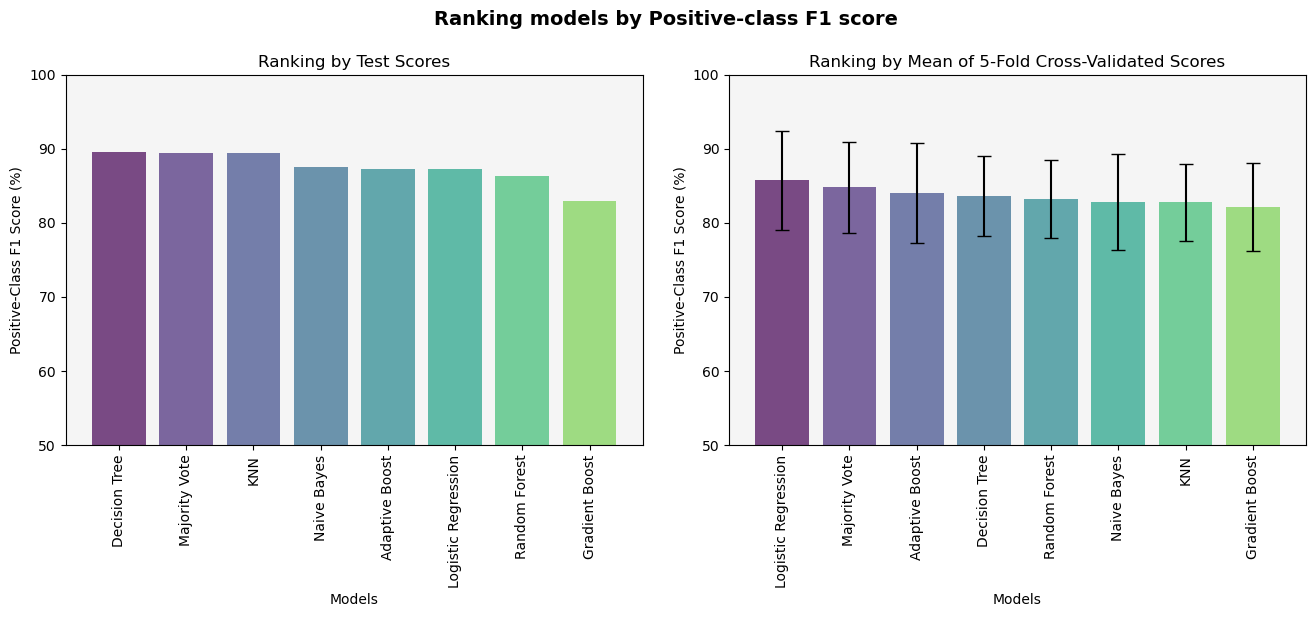

In [27]:
names = ['Logistic Regression', 'Naive Bayes', 'KNN', 'Decision Tree', 'Majority Vote', 'Random Forest', 'Adaptive Boost', 'Gradient Boost']
pipelines = [model_mlr, model_nb, model_knn, model_dt, model_ensemble, model_rf, model_ada, model_gb]
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer
cv_means = []
cv_stds = []
test = []

for name, pipeline in zip(names, pipelines):
    # fit pipeline
    pipeline.fit(X_train, y_train)

    # run training cross validation scoring
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring=custom_scorer, cv=cv)

    # run test scoring
    y_pred_test = pipeline.predict(X_test)
    test_score = base_scorer(y_test, y_pred_test)
    
    # add scores to lists 
    cv_means.append(np.mean(cv_scores))
    cv_stds.append(np.std(cv_scores))
    test.append(test_score)


# Sort names, cv_means cv_stds  based on cv_means values
sorted_indices_cv = np.argsort(cv_means)[::-1]  # Get indices in descending order
sorted_names_cv = [names[i] for i in sorted_indices_cv]
sorted_means_cv = [cv_means[i] for i in sorted_indices_cv]
sorted_stds_cv = [cv_stds[i] for i in sorted_indices_cv]

# Sort names, test scores based on test score values
sorted_indices_test = np.argsort(test)[::-1]  # Get indices in descending order
sorted_names_test = [names[i] for i in sorted_indices_test]
sorted_test = [test[i] for i in sorted_indices_test]

# Use a color map for the bars and set colours for plot areas
cmap = plt.get_cmap("viridis") # Specify colour scheme 
colours = cmap(np.linspace(0, 0.8, len(names))) # generate array from colour scheme. Don't use lightest colours
axes_colour = "#F5F5F5"
plot_colour = '#F3EEE7'

# Plot the first bar chart
fig, axes = plt.subplots(ncols=2, figsize=(16, 5), gridspec_kw={'wspace':0.15})

# Plot the first bar chart
axes[0].bar(sorted_names_test, np.array(sorted_test)*100, capsize=5, align='center', alpha=0.7, color=colours)

# Add plot details
axes[0].set_ylim(50, 100)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Positive-Class F1 Score (%)')
axes[0].set_title('Ranking by Test Scores', fontsize=12)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_facecolor(axes_colour)


# Plot the second bar chart
axes[1].bar(sorted_names_cv, np.array(sorted_means_cv)*100, yerr=np.array(sorted_stds_cv)*100, capsize=5, align='center', alpha=0.7, color=colours)

# Add plot details
axes[1].set_ylim(50, 100)
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Positive-Class F1 Score (%)')
axes[1].set_title('Ranking by Mean of 5-Fold Cross-Validated Scores', fontsize=12)
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_facecolor(axes_colour)

# Set main title
fig.suptitle("Ranking models by Positive-class F1 score", fontweight='bold', fontsize=14)
fig.subplots_adjust(top=0.85)

# show plot and save
plt.savefig(r"images\test_score_results.png", bbox_inches='tight')
plt.show()

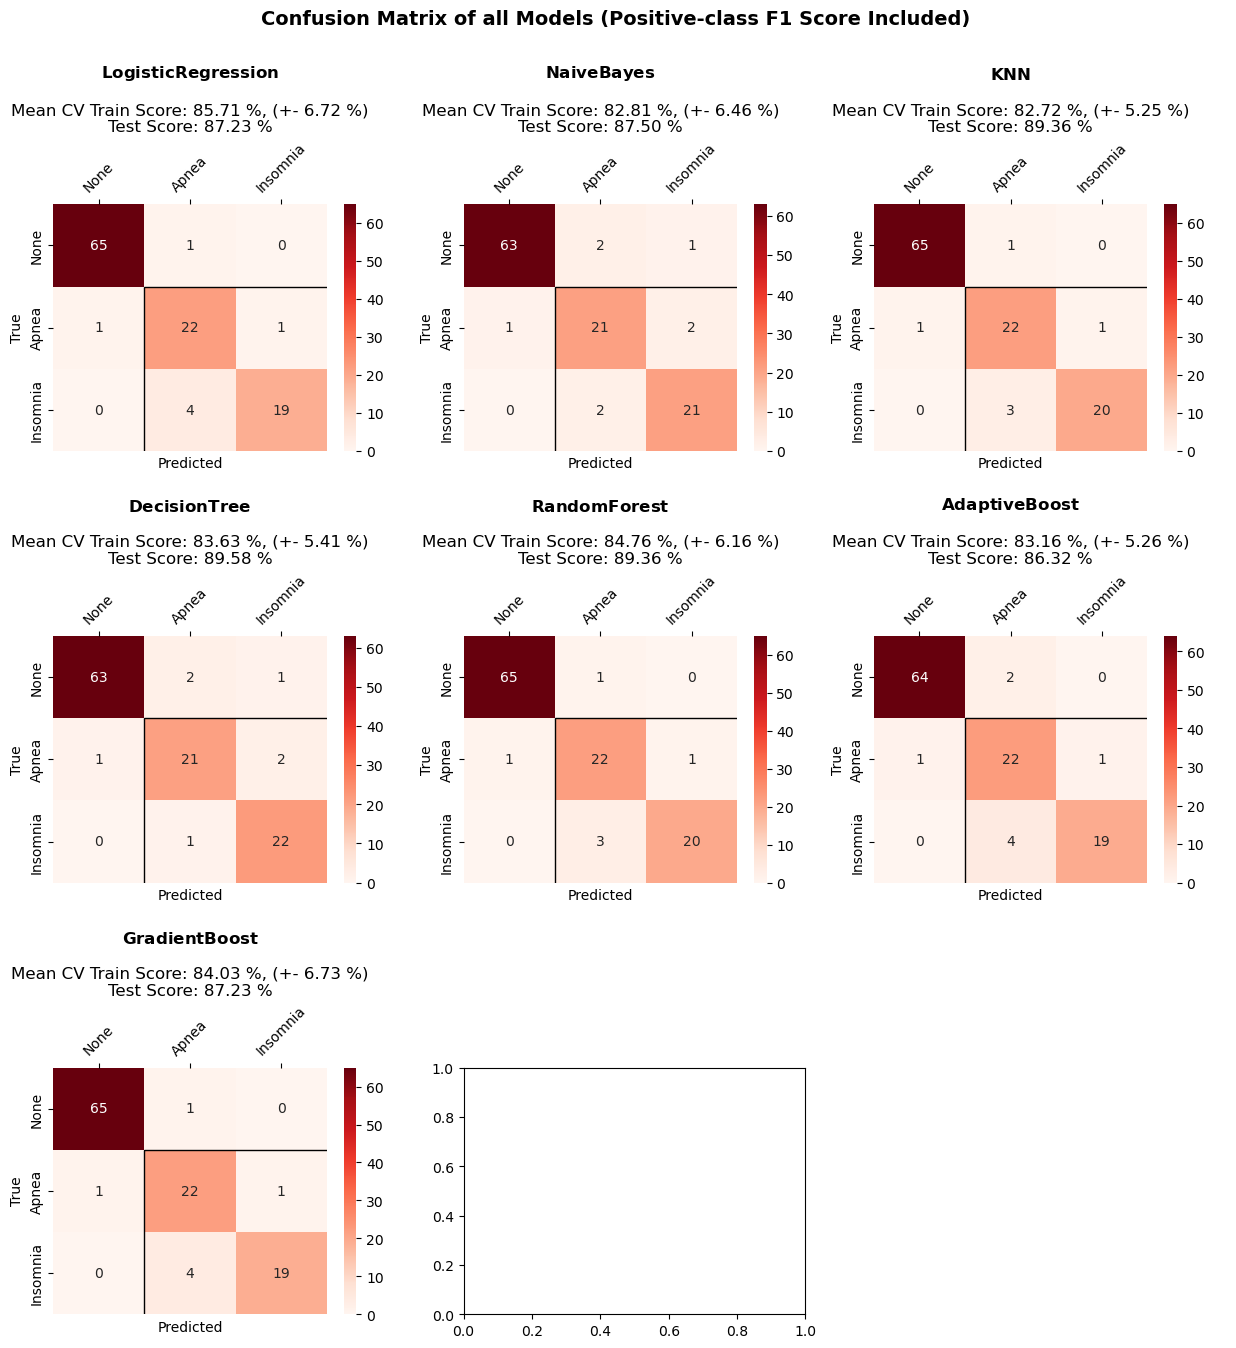

In [73]:
class_labels = ["None", "Apnea", "Insomnia"]
colour = 'white'

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), facecolor=colour)

for ax, (name, pipeline) in zip(axes.ravel(), zip(names, pipelines)):
    # fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Generate prediction and show classification report
    y_pred = pipeline.predict(X_test)

    # Generate textual information on scores to report under each CM.
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring=custom_scorer, cv=cv)
    mean_train_cv_score = np.mean(cv_scores)
    std_train_cv_score  = np.std(cv_scores)
    test_score = base_scorer(y_test, y_pred)
    score_str = f"Mean CV Train Score: {settings.score_formatter(mean_train_cv_score, 2)}, (+- {settings.score_formatter(std_train_cv_score, 2)})\nTest Score: {settings.score_formatter(test_score, 2)}"
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Create a heatmap for the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    
    # Add a border around the bottom right-most 4 cells to emphasise the positive classes
    ax.add_patch(plt.Rectangle((1, 1), 3, 3, fill=False, edgecolor='black', lw=1))

    # Add plot details
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(r"$\mathbf{" + name + "}$\n\n" + score_str + "") # matplotlib expression to make title element bold
    ax.xaxis.set_tick_params(rotation=45)  # Rotate x-axis labels for better visibility
    ax.xaxis.tick_top()  # Place x-axis ticks on top for better alignment

# Make the final axis elements white to effectively hide
axes[2,2].spines['top'].set_color(colour)       # Top border
axes[2,2].spines['bottom'].set_color(colour)    # Bottom border
axes[2,2].spines['left'].set_color(colour)      # Left border
axes[2,2].spines['right'].set_color(colour)     # Right border
axes[2,2].tick_params(axis='x', colors=colour)  # X-axis ticks and labels
axes[2,2].tick_params(axis='y', colors=colour)  # Y-axis ticks and labels
axes[2,2].set_facecolor(colour)

# Add plot title
fig.suptitle("Confusion Matrix of all Models (Positive-class F1 Score Included)", fontweight='bold', fontsize=14)
fig.subplots_adjust(top=0.85)
plt.subplots_adjust(hspace=0.75)


# show plot and save
plt.savefig(r"images\confusion_matrix_results.png", bbox_inches='tight')
plt.show()


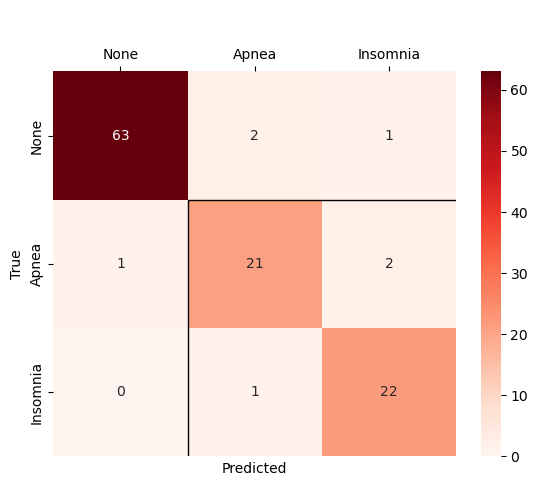

In [57]:
pipeline = model_dt

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 5))

# fit the pipeline
pipeline.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline.predict(X_test)

# Generate textual information on scores to report under each CM.
cv_scores = cross_val_score(pipeline, X_train, y_train, scoring=custom_scorer, cv=cv)
mean_train_cv_score = np.mean(cv_scores)
std_train_cv_score  = np.std(cv_scores)
test_score = base_scorer(y_test, y_pred)
score_str = ""

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Add a border around the bottom right-most 4 cells to emphasise the positive classes
ax.add_patch(plt.Rectangle((1, 1), 3, 3, fill=False, edgecolor='black', lw=1))

# Add plot details
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title(r"$\mathbf{" + "" + "}$\n" + score_str + "") # matplotlib expression to make title element bold
#ax.xaxis.set_tick_params(rotation=45)  # Rotate x-axis labels for better visibility
ax.xaxis.tick_top()  # Place x-axis ticks on top for better alignment

plt.savefig(r"images\confusion_matrix_DT_results.png", bbox_inches='tight')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Majority Vote doesn't improve the test positive F1 score beyond the best of the single models (KNN and Decision Tree)</li>
    <li>Cross validated positive-class F1 score is improved beyond these two models though. It isn't, however, better than the best CV score acheived from the single models: Logisitc Regression at 85%</li>
    <li>Confusion matrix has an identical configuration to the KNN model </li>
    <li>It's clear that majority voting does not present an obvious improvement. This shows the errors are well correlated. </li>
</ul>
</div>
